In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.spatial as spa 
from scipy.stats import multivariate_normal as mnormal

In [2]:
N = np.array([50, 50, 50, 50, 100])

initial_means = np.array([[2.5, 2.5], [-2.5, 2.5], [-2.5, -2.5], [2.5, -2.5], [0, 0]])

variances = np.array([[[0.8, -0.6], [-0.6, 0.8]], [[0.8, 0.6], [0.6, 0.8]], [[0.8, -0.6], [-0.6, 0.8]], [[0.8, 0.6], [0.6, 0.8]], [[1.6, 0.0], [0.0, 1.6]]])

In [3]:
np.random.seed(521)
X1 = np.random.multivariate_normal(initial_means[0], variances[0], N[0])

X2 = np.random.multivariate_normal(initial_means[1], variances[1], N[1])

X3 = np.random.multivariate_normal(initial_means[2], variances[2], N[2])

X4 = np.random.multivariate_normal(initial_means[3], variances[3], N[3])

X5 = np.random.multivariate_normal(initial_means[4], variances[4], N[4])

X = np.concatenate((X1, X2, X3, X4, X5), axis = 0)

print(X.shape)
    
K = 5

(300, 2)


Text(0, 0.5, '$X_{2}$')

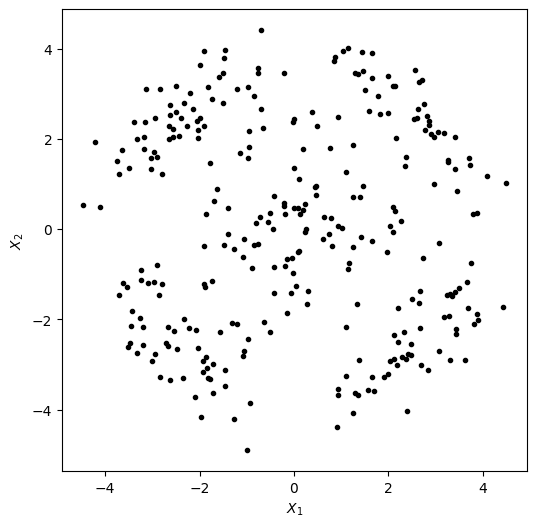

In [4]:
plt.figure(figsize = (6,6))
plt.plot(X[:, 0], X[:, 1], '.', color = "black")
plt.xlabel("$X_{1}$")
plt.ylabel("$X_{2}$")

In [5]:
initial_centroids = np.array([[-3.04394159637351, 0.325097526589432],
[-0.303773972223408, 3.73480678078972],
[1.1758725757789, -2.50984601409393],
[0.91037083863826, 0.876081579213259],
[-1.98588336842854, 2.98466810662225]])

In [6]:
def update_memberships(x, centroids):
    
    D = spa.distance_matrix(centroids, x)
    
    return np.argmin(D, axis = 0)

def update_centroids(x, memberships):
    
    if memberships is None: 
        
        centroids = X[np.random.choice(range(N), K), :]
    
    else:
        
        centroids = np.vstack([np.mean(X[memberships == k], axis = 0) for k in range(K)])
        
    return centroids

In [7]:
# Initializing covariances and means
covars = []
memberships = update_memberships(X, initial_centroids)
for k in range(K):
    
    matrix = np.zeros((2,2))
    
    for x in X[memberships == k]:
    
        matrix += np.matmul((x - initial_centroids[k])[:,None], (x - initial_centroids[k])[None, :])
    
    
    covars.append(matrix / X[memberships == k].shape[0])

covars = np.array(covars)
print("Covariances: \n\n" + str(covars) + "\n")
priors = np.vstack([X[memberships == k].shape[0] / np.sum(N) for k in range(K)])
print("Priors: \n\n" + str(priors))
        

Covariances: 

[[[ 0.80960595 -0.46324754]
  [-0.46324754  3.80320544]]

 [[ 2.33101228 -0.30181853]
  [-0.30181853  0.38012914]]

 [[ 3.80999901  0.69724578]
  [ 0.69724578  0.83400957]]

 [[ 2.28896475  0.77160508]
  [ 0.77160508  1.1703097 ]]

 [[ 0.48980951  0.08037701]
  [ 0.08037701  0.53808923]]]

Priors: 

[[0.19333333]
 [0.08666667]
 [0.28333333]
 [0.29666667]
 [0.14      ]]


In [8]:
def update_priors(hik):
    
    priors = [np.sum(hik[k], axis = 0) for k in range(K)]
    
    return np.expand_dims(np.array(priors) / hik.shape[1], axis = 1)
        
def update_means(hik, x):
     
    return np.array([np.matmul(hik[k,:], x) / np.sum(hik[k], axis = 0) for k in range(K)])
    
    
def update_covars(hik, x, means):
    
    updated_covars = []
    
    for k in range(K):
        
        result = np.zeros((2,2))
        
        for i in range(x.shape[0]):
            
            result += (hik[k][i] * np.matmul((x[i] - means[k])[:, None], (x[i] - means[k])[None,:]))
        
        updated_covars.append(result / np.sum(hik[k], axis = 0))
        
    
    return np.array(updated_covars)
            
   

In [9]:
def print_info():
    #print(hik.shape)
    #print(priors.shape)
    print(means)
    #print(covars)

In [10]:
max_iteration = 100
iteration = 0
hik = np.zeros((K, np.sum(N)))
means = initial_centroids
print_info()
while iteration < max_iteration: 
    pdfs = []
    for k in range(K):
        pdf = mnormal(means[k], covars[k]).pdf(X) * priors[k]
        pdfs.append(pdf)
    
    pdfs = np.array(pdfs)
    hik = pdfs / np.sum(pdfs, axis = 0)
    
    priors = update_priors(hik)
    means = update_means(hik, X)
    covars = update_covars(hik, X, means)
    iteration += 1
    print(iteration)
    print_info()
memberships=np.argmax(hik, axis = 0)

[[-3.0439416   0.32509753]
 [-0.30377397  3.73480678]
 [ 1.17587258 -2.50984601]
 [ 0.91037084  0.87608158]
 [-1.98588337  2.98466811]]
1
[[-2.83204663 -0.51959591]
 [ 0.80679373  3.44371362]
 [ 1.08918442 -2.52350848]
 [ 1.03524085  0.8373497 ]
 [-2.01853916  2.67205185]]
2
[[-2.8104465  -0.81667379]
 [ 0.98786109  3.42270105]
 [ 1.16787421 -2.52364261]
 [ 0.98511749  0.75774992]
 [-2.11162158  2.62136664]]
3
[[-2.78025109 -1.1510422 ]
 [ 1.14770691  3.39786943]
 [ 1.26106614 -2.52510423]
 [ 0.9335275   0.70840155]
 [-2.18668225  2.58710125]]
4
[[-2.7378241  -1.50225241]
 [ 1.31726351  3.36269707]
 [ 1.37411038 -2.52427414]
 [ 0.88199456  0.67200378]
 [-2.24532976  2.56225972]]
5
[[-2.68458896 -1.84547297]
 [ 1.50406141  3.31489623]
 [ 1.51439806 -2.51938927]
 [ 0.82817375  0.63942412]
 [-2.28905646  2.54311646]]
6
[[-2.62123365 -2.14679167]
 [ 1.70112289  3.25142344]
 [ 1.68716053 -2.50958938]
 [ 0.76797643  0.60324289]
 [-2.32073762  2.52591328]]
7
[[-2.5549782  -2.35364602]
 [ 1.88

50
47
51
97
55


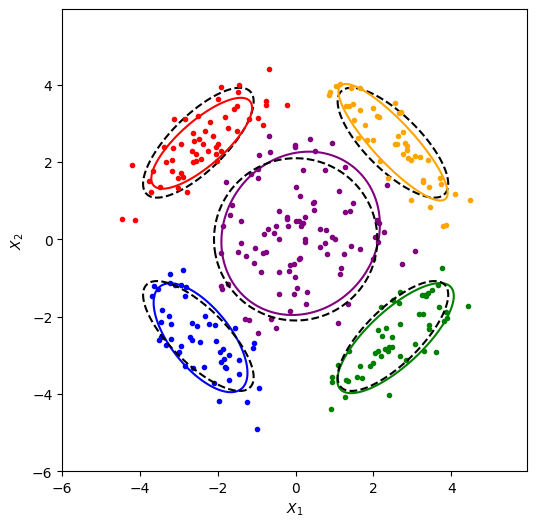

In [21]:
cluster_colors = ["blue", "orange", "green", "purple", "red"]
plt.figure(figsize = (6, 6))
plt.xlabel("$X_{1}$")
plt.ylabel("$X_{2}$")
x, y = np.mgrid[-6:6:.05,-6:6:.05]
points = np.dstack((x, y))


for k in range(K):
    original_classes = mnormal(initial_means[k], 2*variances[k]).pdf(points)
    predicted_classes = mnormal(means[k], 2*covars[k]).pdf(points)
    print(np.sum((memberships == k)))
    plt.plot(X[memberships == k][:, 0], X[memberships == k][:, 1], ". " ,color = cluster_colors[k])
    plt.contour(x, y, original_classes, levels = 1, linestyles = "dashed", colors = "black")
    plt.contour(x, y, predicted_classes, levels = 1, colors = cluster_colors[k])
plt.show()